# Probabilistic PCA on different selected brain region

In [1]:
import os
import sys
import time

In [2]:
import numpy as np
import scipy as sci
import pandas as pd
import seaborn as sns
from scipy import optimize
import matplotlib.pyplot as plt

In [3]:
import theano
import theano.tensor as tt
import theano.tensor.slinalg as sla
import theano.tensor.nlinalg as nla

import pymc3 as pm

In [ ]:
from scipy.stats import norm


In [4]:
import ssm
from ssm.util import find_permutation
from ssm.plots import gradient_cmap, white_to_color_cmap

In [5]:
color_names = [
    "windows blue",
    "red"
    ]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
theano.config.exception_verbosity = 'high'
os.environ["MKL_THREADING_LAYER"]="GNU"

In [8]:
print('Running on numpy: v{}'.format(np.version.version))
print('Running on theano: v{}'.format(theano.version.version))
print('Running on PYMC3: v{}'.format(pm.__version__))

Running on numpy: v1.18.1
Running on theano: v1.0.4
Running on PYMC3: v3.8


In [9]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors
from IPython.display import HTML

In [10]:
%pylab inline

sns.set_style("white")
sns.set_context("talk")

Populating the interactive namespace from numpy and matplotlib


In [11]:
cwd = os.getcwd()
cwd

'/Users/meysamhashemi/WORK/CurrentWork_codes/PPCA'

In [12]:
Sim_data=np.load(cwd+'/data_input_files/data_input_mpr_slnet_decim360_001.npz')

In [13]:
for elemets in Sim_data.keys():
    print (elemets)

nd
nn
nt
dt
nsigma
Ts
t0
ds_decim
G
SC
Obs_v
Obs_r
delta_true
eta_true
J_true
rlim
vlim


In [14]:
nn=Sim_data['nn']
Ts=Sim_data['Ts']
Obs_v=Sim_data['Obs_v']
Obs_r=Sim_data['Obs_r']

In [15]:
Obs_v.shape, Ts.shape

((84, 1667), (1667,))

In [16]:
def scale(X, x_min, x_max):
    nom = (X-X.min(axis=0))*(x_max-x_min)
    denom = X.max(axis=0) - X.min(axis=0)
    denom[denom==0] = 1
    return x_min + nom/denom 

In [17]:
Obs_v_scaled = scale(Obs_v, -.15, 1.1)
#Obs_v_scaled = scale(Obs_v, 1., 2.)

In [18]:
Obs_v_scaled.shape

(84, 1667)

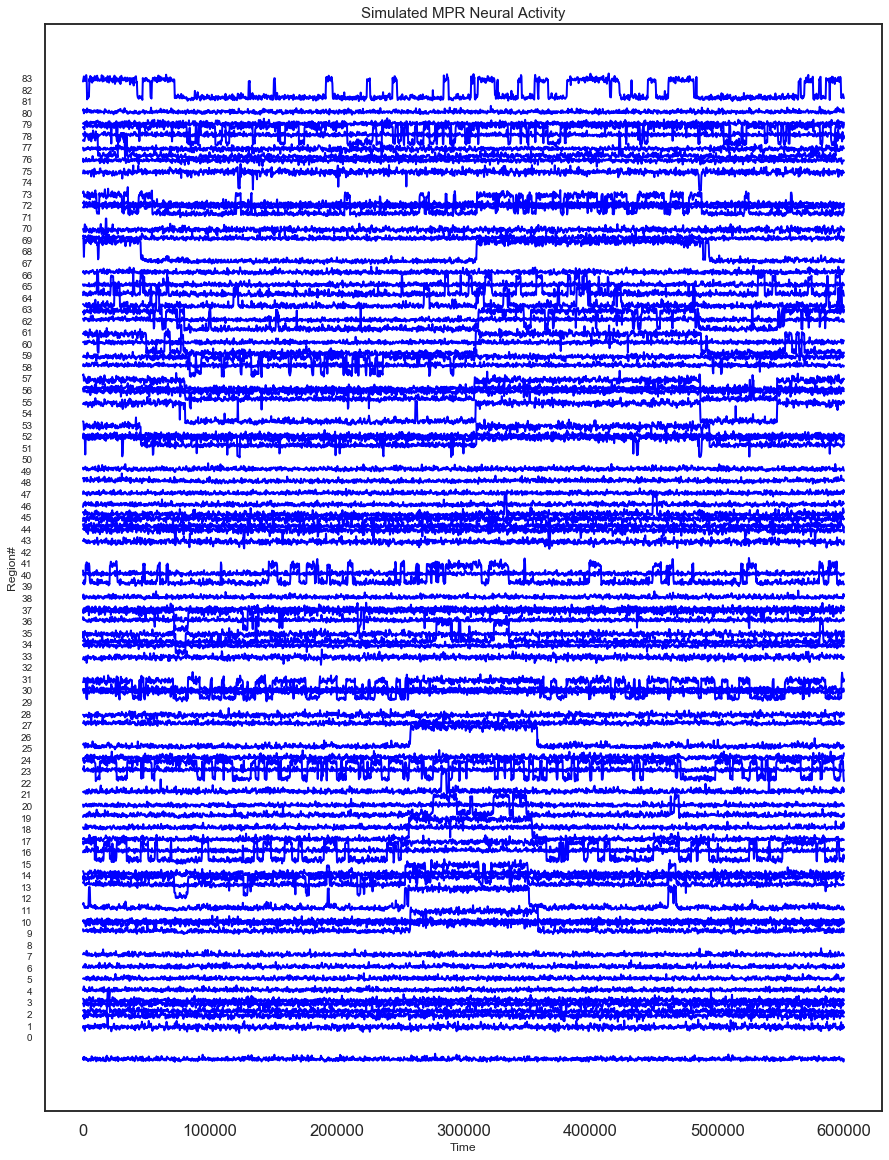

In [19]:
plt.figure(figsize=(15,20))
plt.plot(Ts, Obs_v.T + np.r_[0:nn], '-b', linewidth=2)
plt.yticks(np.r_[0:nn], np.r_[0:nn], fontsize=10)
plt.title("Simulated MPR Neural Activity",fontsize=15)
plt.xlabel('Time',fontsize=12)
plt.ylabel('Region#',fontsize=12)
plt.savefig(os.path.join(cwd+'/Figs',"MPR_SyntheticSource.png"))
plt.show()

# Selecting Some node activities 

In [20]:
Ns_=np.array([0, 16, 36, 66, 78, 83])

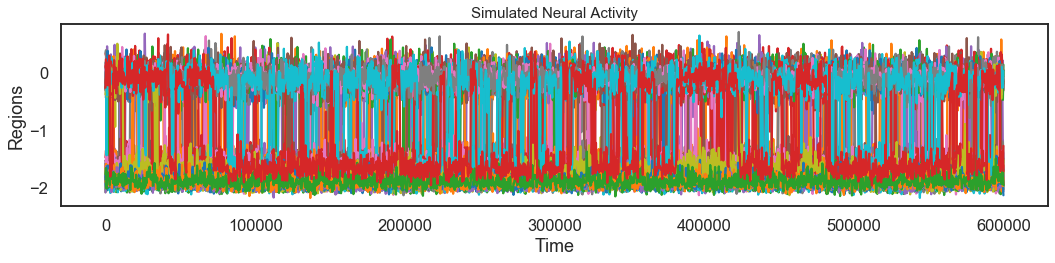

In [21]:
plt.figure(figsize=(15, 4))
plt.plot(Ts, Obs_v.T)
plt.xlabel("Time")
plt.ylabel("Regions")
plt.title("Simulated Neural Activity",fontsize=15)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/Figs',"MPR_Selected_SyntheticSource_nn.png"))
plt.show()     

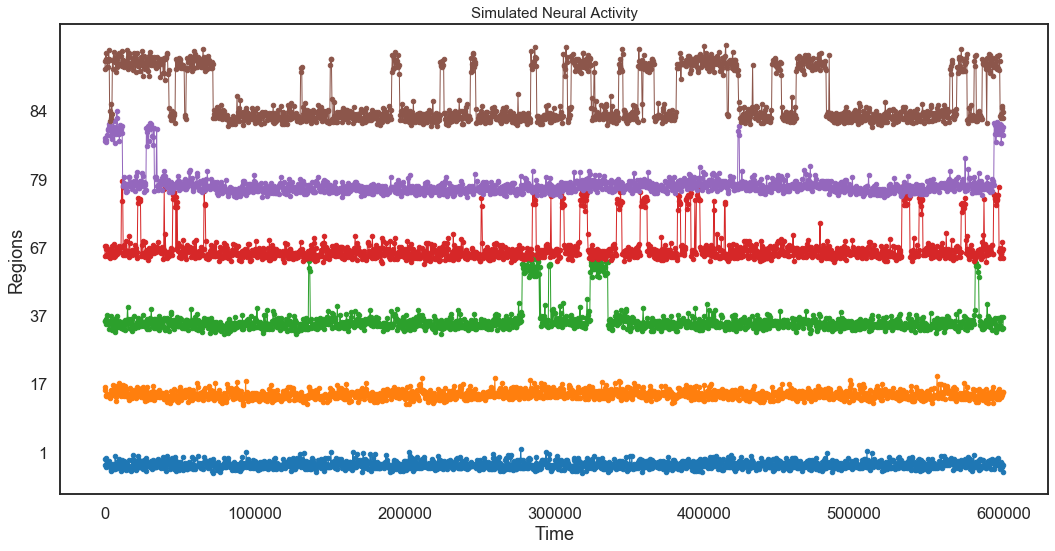

In [22]:
plt.figure(figsize=(15, 8))
i=0
for ii in (Ns_):
    i=i+1
    plt.plot(Ts, Obs_v[ii, :].T+ 2*i, '.-', lw=1)
plt.yticks(2*np.r_[0:Ns_.size]+.5, Ns_+1)
plt.xlabel("Time")
plt.ylabel("Regions")
plt.title("Simulated Neural Activity",fontsize=15)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/Figs',"MPR_Selected_SyntheticSourceNodes_nn.png"))
plt.show()     

In [23]:
Obs_v.shape, Obs_r.shape

((84, 1667), (84, 1667))

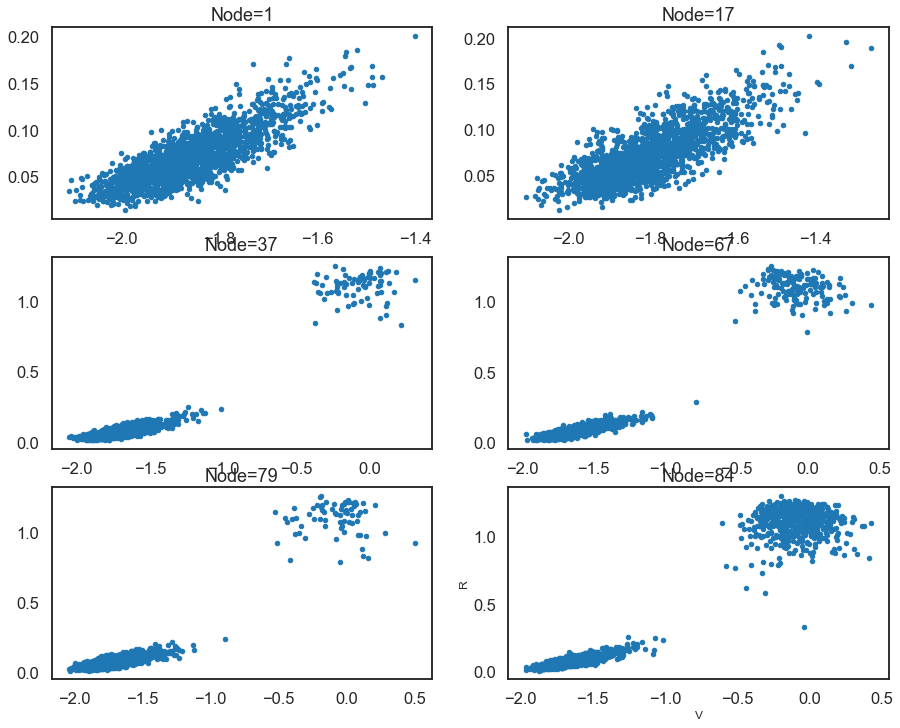

In [24]:
plt.figure(figsize=(15, 12))
i=0
for ii in (Ns_):
    i=i+1
    plt.subplot(3,2,i)
    plt.plot(Obs_v[ii, :], Obs_r[ii, :], '.', lw=.1)
    plt.title("Node={:d}".format((ii)+1))
plt.xlabel('V',fontsize=12)
plt.ylabel('R',fontsize=12)
plt.savefig(os.path.join(cwd+'/Figs',"MPR_Selected_SyntheticSourcePhasePlaneRV.png"))
plt.show()     

# Probabilistic PCA on a selected brain region

In [25]:
ns=0

In [26]:
Obs_v[ns, :].shape, Obs_r[ns, :].shape

((1667,), (1667,))

In [27]:
len(Obs_v[ns, :])

1667

In [28]:
N = len(Obs_v[ns, :])  # number of data points
D = 2  # data dimensionality
K = 1  # latent dimensionality

In [29]:
x_train=np.stack((Obs_v[ns, :], Obs_r[ns, :]))

In [30]:
x_train.shape

(2, 1667)

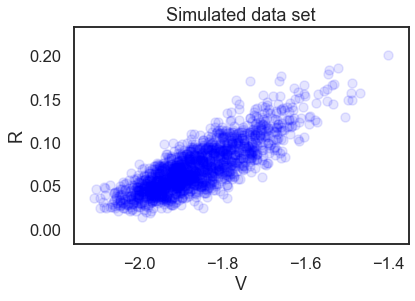

In [44]:
plt.figsize=(8, 4)
plt.scatter(x_train[0, :], x_train[1, :], color='blue', alpha=0.1)
#plt.axis([-2.2, -1.25, 0, .2])
#plt.plot(0,0,'ro')
plt.title("Simulated data set")
plt.xlabel('V')
plt.ylabel('R')
plt.show()

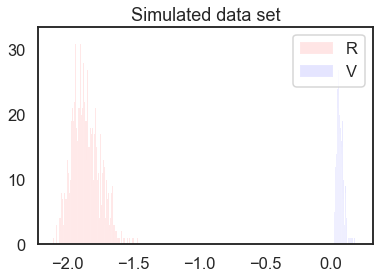

In [47]:
plt.figsize=(8, 4)
#plt.scatter(x_train[0, :], x_train[1, :], color='blue', alpha=0.1)
plt.hist(x_train[0, :], color='r', alpha=0.1, bins=200, label='R')
plt.hist(x_train[1, :], color='b', alpha=0.1, bins=200, label='V')
#plt.axis([-10, 10, -10, 10])
plt.title("Simulated data set")
plt.legend(loc=1)
plt.show()

In [ ]:
data=x_train[0, :]

# Fit a normal distribution to the data:
mu, std = norm.fit(data)

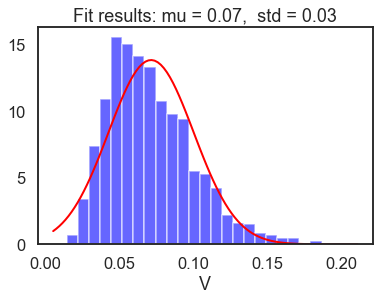

In [46]:
plt.figsize=(8, 4)

# Plot the histogram.
plt.hist(data, bins=25, density=True, alpha=0.6, color='b')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'r', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)
plt.xlabel('V')
plt.show()

In [48]:
data=x_train[1, :]

# Fit a normal distribution to the data:
mu, std = norm.fit(data)

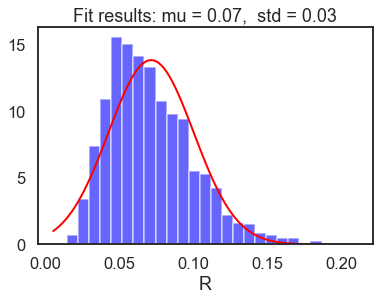

In [49]:
plt.figsize=(8, 4)

# Plot the histogram.
plt.hist(data, bins=25, density=True, alpha=0.6, color='b')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'r', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)
plt.xlabel('R')
plt.show()

In [65]:
tt.zeros([D, K])-1.8

Elemwise{sub,no_inplace}.0

In [66]:
with pm.Model() as PPCA:
    w = pm.Normal('w', mu=tt.zeros([D, K])-1.8, sd=1.0 * tt.ones([D, K]), shape=[D, K])
    z = pm.Normal('z', mu=tt.zeros([N, K]), sd=1.0*tt.ones([N, K]), shape=[N, K])
    sigma = pm.HalfCauchy('sigma', beta=1.0)
    x = pm.Normal('x', mu=w.dot(z.T), sd=sigma*tt.ones([D, N]), shape=[D, N], observed=x_train)  

    trace = pm.sample(draws=2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, z, w]
Sampling 2 chains, 0 divergences: 100%|██████████| 8000/8000 [00:36<00:00, 217.03draws/s]
The acceptance probability does not match the target. It is 0.8876165162154298, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6999603096061197, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


In [67]:
#print(trace.varnames)

In [68]:
#trace['w'].shape, trace['z'].shape

In [69]:
# pm.traceplot(trace)
# plt.show()

In [70]:
w=np.asarray(trace.get_values('w', burn=0, combine=True))
z=np.asarray(trace.get_values('z', burn=0, combine=True))
sigma=np.asarray(trace.get_values('sigma', burn=0, combine=True))

In [71]:
w.shape, z.shape

((4000, 2, 1), (4000, 1667, 1))

In [72]:
w_est=np.mean(w, axis=0)
z_est=np.mean(z, axis=0)
sigma_est=np.mean(sigma, axis=0)

In [73]:
sigma_est

0.03226922462734916

In [74]:
w_est.shape, z_est.shape

((2, 1), (1667, 1))

In [75]:
print("Inferred principal axes:")
print(w_est)

Inferred principal axes:
[[-1.85058329]
 [ 0.06944457]]


In [76]:
print(w_est[1]/w_est[0])

[-0.03752578]


In [77]:
z_est.mean()

1.0061997883147769

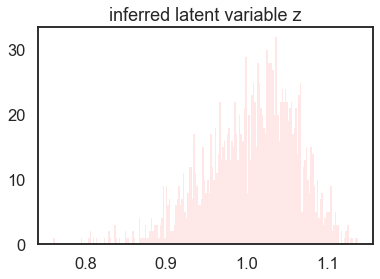

In [78]:
plt.figsize=(8, 4)
#plt.scatter(x_train[0, :], x_train[1, :], color='blue', alpha=0.1)
plt.hist(z_est, color='r', alpha=0.1, bins=200)
#plt.axis([-10, 10, -10, 10])
plt.title("inferred latent variable z")
plt.show()

In [79]:
#generate trace from posterior
ppc_trace = pm.sample_posterior_predictive(trace, samples=2000, model=PPCA)

100%|██████████| 2000/2000 [00:02<00:00, 738.60it/s]


In [80]:
for key,val in ppc_trace.items():
    print (key, "=>", val)
    print (val.shape)

x => [[[-1.87868204 -1.65347147 -1.91354955 ... -1.96577775 -2.08138186
   -1.874533  ]
  [ 0.1159965   0.08913843  0.07346588 ...  0.09129542  0.04360278
    0.03913768]]

 [[-1.92707339 -1.72580631 -2.00426293 ... -1.93473175 -2.11747928
   -1.9165766 ]
  [ 0.06418395  0.08681333  0.14041431 ...  0.13526876  0.05069733
    0.06446364]]

 [[-1.8334784  -1.67733124 -1.84926617 ... -1.93729936 -2.0476178
   -1.85294754]
  [ 0.03993649  0.03784547  0.06696059 ...  0.07203145  0.1073489
    0.06571283]]

 ...

 [[-1.8911467  -1.70851214 -1.95480985 ... -2.03842149 -2.23008764
   -1.8641126 ]
  [ 0.09461647  0.05372088  0.05924955 ...  0.05411971  0.06581494
    0.08688864]]

 [[-1.82159746 -1.66063113 -1.96624849 ... -1.89681364 -2.14551424
   -1.88057723]
  [ 0.07121078  0.04109239  0.10326216 ...  0.12785221  0.08591371
    0.08874022]]

 [[-1.83314902 -1.62479489 -1.97704745 ... -1.95948963 -2.13640613
   -1.89601037]
  [ 0.09603124  0.09778341  0.08730592 ...  0.07816074  0.10723215
 

In [81]:
x_gen=ppc_trace['x']

In [82]:
x_train.shape, x_gen.shape

((2, 1667), (2000, 2, 1667))

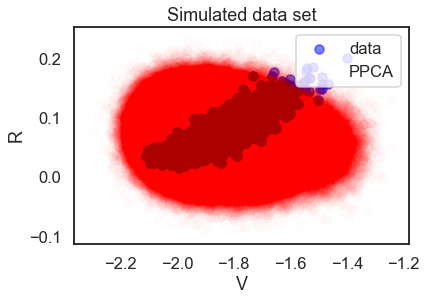

In [83]:
#plt.figure(figsize=(4, 4))
plt.scatter(x_train[0, :], x_train[1, :], color='b', alpha=0.5, label='data')
plt.scatter(x_gen[:,0, :], x_gen[:,1, :],  color='r', alpha=0.01, label='PPCA')
#plt.axis([-3.2, -.25, -2, 2])
plt.title("Simulated data set")
plt.legend()
plt.xlabel('V')
plt.ylabel('R')
plt.savefig(os.path.join(cwd+"/Figs","PPCA_Node_0.png"))
plt.show()

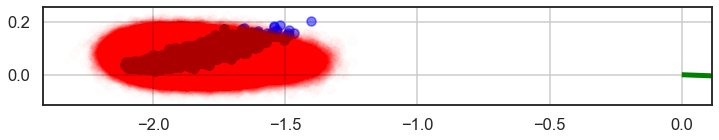

In [84]:
X = np.array((0.))
Y= np.array((0.0))
U = -w_est[0]
V = -w_est[1]

fig, ax = plt.subplots(1,1,figsize=(12,3))
plt.scatter(x_train[0, :], x_train[1, :], color='b', alpha=0.5)
plt.scatter(x_gen[:,0, :], x_gen[:,1, :],  color='r', alpha=0.01)
q = ax.quiver(X, Y, U, V,units='xy' ,scale=.0022, color='green')
plt.grid()
ax.set_aspect('equal')
# plt.xlim(-2,0)
# plt.ylim(0,1)
plt.show()

# Probabilistic PCA on a selected brain region

In [ ]:
ns=36

In [ ]:
Obs_v[ns, :].shape, Obs_r[ns, :].shape

In [ ]:
len(Obs_v[ns, :])

In [ ]:
N = len(Obs_v[ns, :])  # number of data points
D = 2  # data dimensionality
K = 1  # latent dimensionality

In [ ]:
x_train=np.stack((Obs_v[ns, :]+1.86, Obs_r[ns, :]-.07))

In [ ]:
x_train.shape

In [ ]:
plt.scatter(x_train[0, :], x_train[1, :], color='blue', alpha=0.1)
#plt.axis([-2.2, -1.25, 0, .2])
plt.plot(0,0,'ro')
plt.title("Simulated data set")
plt.show()

In [ ]:
#plt.scatter(x_train[0, :], x_train[1, :], color='blue', alpha=0.1)
plt.hist(x_train[0, :], color='r', alpha=0.1, bins=200)
plt.hist(x_train[1, :], color='b', alpha=0.1, bins=200)
#plt.axis([-10, 10, -10, 10])
plt.title("Simulated data set")
plt.show()

In [ ]:
from scipy.stats import norm


data=x_train[0, :]

# Fit a normal distribution to the data:
mu, std = norm.fit(data)

# Plot the histogram.
plt.hist(data, bins=25, density=True, alpha=0.6, color='g')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

In [ ]:
from scipy.stats import norm


data=x_train[1, :]

# Fit a normal distribution to the data:
mu, std = norm.fit(data)

# Plot the histogram.
plt.hist(data, bins=25, density=True, alpha=0.6, color='g')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

In [ ]:
with pm.Model() as PPCA:
    w = pm.Normal('w', mu=tt.zeros([D, K]), sd=1.0 * tt.ones([D, K]), shape=[D, K])
    z = pm.Normal('z', mu=tt.zeros([N, K]), sd=1.0*tt.ones([N, K]), shape=[N, K])
    sigma = pm.HalfCauchy('sigma', beta=1.0)
    x = pm.Normal('x', mu=w.dot(z.T), sd=sigma*tt.ones([D, N]), shape=[D, N], observed=x_train)  

    trace = pm.sample(draws=2000, tune=2000)


In [ ]:
#print(trace.varnames)

In [ ]:
#trace['w'].shape, trace['z'].shape

In [ ]:
# pm.traceplot(trace)
# plt.show()

In [ ]:
w=np.asarray(trace.get_values('w', burn=0, combine=True))
z=np.asarray(trace.get_values('z', burn=0, combine=True))
sigma=np.asarray(trace.get_values('sigma', burn=0, combine=True))

In [ ]:
w.shape, z.shape

In [ ]:
w_est=np.mean(w, axis=0)
z_est=np.mean(z, axis=0)
sigma_est=np.mean(sigma, axis=0)

In [ ]:
sigma_est

In [ ]:
w_est.shape, z_est.shape

In [ ]:
print("Inferred principal axes:")
print(w_est)

In [ ]:
print(w_est[1]/w_est[0])

In [ ]:
z_est.mean()

In [ ]:
#plt.scatter(x_train[0, :], x_train[1, :], color='blue', alpha=0.1)
plt.hist(z_est, color='r', alpha=0.1, bins=200)
#plt.axis([-10, 10, -10, 10])
plt.title("latent variable z")
plt.show()

In [ ]:
#generate trace from posterior
ppc_trace = pm.sample_posterior_predictive(trace, samples=2000, model=PPCA)

In [ ]:
for key,val in ppc_trace.items():
    print (key, "=>", val)
    print (val.shape)

In [ ]:
x_gen=ppc_trace['x']

In [ ]:
x_train.shape, x_gen.shape

In [ ]:
#plt.figure(figsize=(4, 4))
plt.scatter(x_train[0, :], x_train[1, :], color='b', alpha=0.5, label='data')
plt.scatter(x_gen[:,0, :], x_gen[:,1, :],  color='r', alpha=0.01, label='PPCA')
#plt.axis([-3.2, -.25, -2, 2])
plt.title("Simulated data set")
plt.legend()
plt.savefig(os.path.join(cwd+"/Figs","PPCA_Node_36.png"))

plt.show()

In [ ]:
X = np.array((0.))
Y= np.array((0.0))
U = -w_est[0]
V = -w_est[1]

fig, ax = plt.subplots(1,1,figsize=(12,3))
plt.scatter(x_train[0, :], x_train[1, :], color='b', alpha=0.5)
plt.scatter(x_gen[:,0, :], x_gen[:,1, :],  color='r', alpha=0.01)
q = ax.quiver(X, Y, U, V,units='xy' ,scale=.2, color='green')
plt.grid()
ax.set_aspect('equal')
# plt.xlim(-2,0)
# plt.ylim(0,1)
plt.show()

# Probabilistic PCA on a selected brain region

In [85]:
ns=83

In [86]:
Obs_v[ns, :].shape, Obs_r[ns, :].shape

((1667,), (1667,))

In [87]:
len(Obs_v[ns, :])

1667

In [88]:
N = len(Obs_v[ns, :])  # number of data points
D = 2  # data dimensionality
K = 1  # latent dimensionality

In [89]:
x_train=np.stack((Obs_v[ns, :], Obs_r[ns, :]))

In [90]:
x_train.shape

(2, 1667)

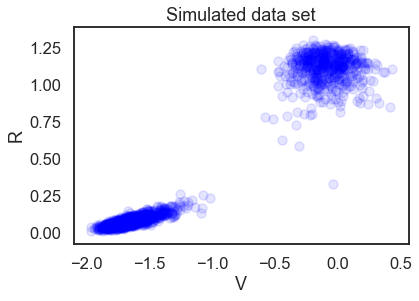

In [93]:
plt.figsize=(8, 4)
plt.scatter(x_train[0, :], x_train[1, :], color='blue', alpha=0.1)
#plt.axis([-2.2, -1.25, 0, .2])
#plt.plot(0,0,'ro')
plt.title("Simulated data set")
plt.xlabel('V')
plt.ylabel('R')
plt.show()

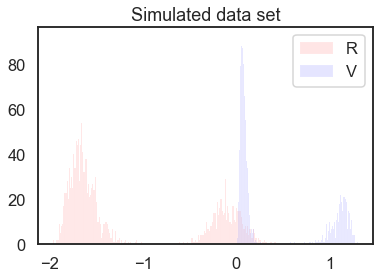

In [94]:
plt.figsize=(8, 4)
#plt.scatter(x_train[0, :], x_train[1, :], color='blue', alpha=0.1)
plt.hist(x_train[0, :], color='r', alpha=0.1, bins=200, label='R')
plt.hist(x_train[1, :], color='b', alpha=0.1, bins=200, label='V')
#plt.axis([-10, 10, -10, 10])
plt.title("Simulated data set")
plt.legend(loc=1)
plt.show()

In [95]:
data=x_train[0, :]

# Fit a normal distribution to the data:
mu, std = norm.fit(data)

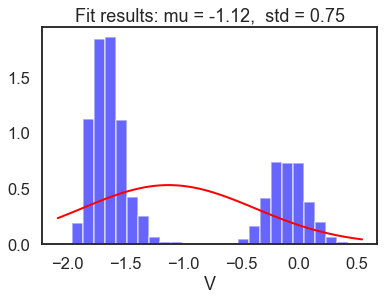

In [96]:
plt.figsize=(8, 4)

# Plot the histogram.
plt.hist(data, bins=25, density=True, alpha=0.6, color='b')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'r', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)
plt.xlabel('V')
plt.show()

In [97]:
data=x_train[1, :]

# Fit a normal distribution to the data:
mu, std = norm.fit(data)


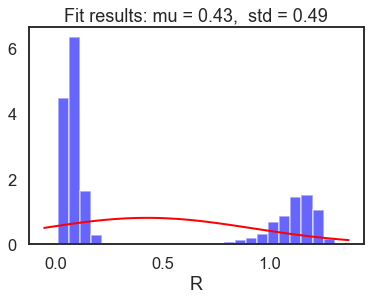

In [98]:
plt.figsize=(8, 4)

# Plot the histogram.
plt.hist(data, bins=25, density=True, alpha=0.6, color='b')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'r', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)
plt.xlabel('R')
plt.show()

In [190]:
with pm.Model() as PPCA:
    w = pm.Normal('w', mu=tt.zeros([D, K]), sd=2.0 * tt.ones([D, K]), shape=[D, K])
    z = pm.Normal('z', mu=tt.zeros([N, K]), sd=1.0*tt.ones([N, K]), shape=[N, K])
    sigma = pm.HalfCauchy('sigma', beta=.01)
    x = pm.Normal('x', mu=w.dot(z.T), sd=sigma*tt.ones([D, N]), shape=[D, N], observed=x_train)  

    trace = pm.sample(draws=2000, tune=2000)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, z, w]
Sampling 2 chains, 0 divergences: 100%|██████████| 8000/8000 [00:23<00:00, 338.10draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [191]:
#print(trace.varnames)

In [192]:
#trace['w'].shape, trace['z'].shape

In [193]:
# pm.traceplot(trace)
# plt.show()

In [194]:
w=np.asarray(trace.get_values('w', burn=0, combine=True))
z=np.asarray(trace.get_values('z', burn=0, combine=True))
sigma=np.asarray(trace.get_values('sigma', burn=0, combine=True))

In [195]:
w.shape, z.shape

((4000, 2, 1), (4000, 1667, 1))

In [196]:
w_est=np.mean(w, axis=0)
z_est=np.mean(z, axis=0)
sigma_est=np.mean(sigma, axis=0)

In [210]:
sigma_est

0.6422722222039344

In [198]:
w_est.shape, z_est.shape

((2, 1), (1667, 1))

In [199]:
print("Inferred principal axes:")
print(w_est)

Inferred principal axes:
[[-1.18930702]
 [ 0.10049194]]


In [200]:
print(w_est[1]/w_est[0])

[-0.08449621]


In [201]:
z_est.mean()

0.7504038652504903

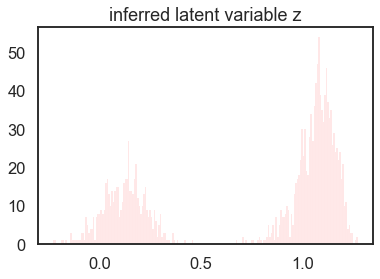

In [202]:
plt.figsize=(8, 4)
#plt.scatter(x_train[0, :], x_train[1, :], color='blue', alpha=0.1)
plt.hist(z_est, color='r', alpha=0.1, bins=200)
#plt.axis([-10, 10, -10, 10])
plt.title("inferred latent variable z")
plt.show()

In [203]:
#generate trace from posterior
ppc_trace = pm.sample_posterior_predictive(trace, samples=2000, model=PPCA)

100%|██████████| 2000/2000 [00:02<00:00, 806.19it/s]


In [204]:
for key,val in ppc_trace.items():
    print (key, "=>", val)
    print (val.shape)

x => [[[-0.15735713  0.50596077  0.64569328 ... -0.74115327  0.19884406
   -1.85460396]
  [-0.66045614 -0.3971552   0.19935594 ...  0.39705346 -1.32515845
   -0.42179951]]

 [[ 0.01631136  0.07152293 -0.36353721 ... -2.30642565 -1.16468531
   -1.90610771]
  [ 0.49627776  0.03403764 -0.03322856 ...  1.51649212  0.88890118
   -0.16942106]]

 [[ 0.27320749 -1.20804825  0.31647929 ... -0.29119216 -2.24010762
   -1.0463514 ]
  [-0.31898658 -0.10995101  0.05746123 ...  0.05467951 -0.09307032
    0.99225009]]

 ...

 [[ 1.98017978 -0.47508258 -0.11244706 ... -1.97148005 -1.07277236
   -1.51089284]
  [-1.05641197  0.12916223  1.46869662 ...  0.73646034  0.21151069
    0.86422453]]

 [[-0.7612025   0.58301926  0.78729375 ... -1.03289622 -1.05484244
   -1.27866017]
  [ 0.48292169  1.02815536 -1.06045742 ... -0.18920412 -0.01807045
   -0.97347658]]

 [[-0.21993616 -1.08085444  0.01405978 ... -1.50870549  0.36723767
   -0.54125929]
  [-1.16447228 -0.82895802  0.07242162 ... -0.16673978  0.41202417

In [205]:
x_gen=ppc_trace['x']

In [206]:
x_train.shape, x_gen.shape

((2, 1667), (2000, 2, 1667))

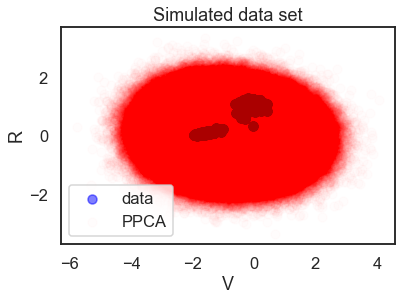

In [207]:
#plt.figure(figsize=(4, 4))
plt.scatter(x_train[0, :], x_train[1, :], color='b', alpha=0.5, label='data')
plt.scatter(x_gen[:,0, :], x_gen[:,1, :],  color='r', alpha=0.01, label='PPCA')
#plt.axis([-3.2, -.25, -2, 2])
plt.title("Simulated data set")
plt.legend()
plt.xlabel('V')
plt.ylabel('R')
plt.savefig(os.path.join(cwd+"/Figs","PPCA_Node_84.png"))
plt.show()

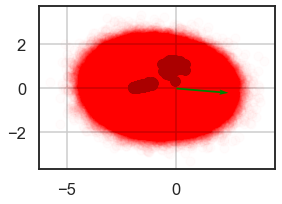

In [208]:
X = np.array((0.))
Y= np.array((0.0))
U = -w_est[0]
V = -w_est[1]

fig, ax = plt.subplots(1,1,figsize=(12,3))
plt.scatter(x_train[0, :], x_train[1, :], color='b', alpha=0.5)
plt.scatter(x_gen[:,0, :], x_gen[:,1, :],  color='r', alpha=0.01)
q = ax.quiver(X, Y, U, V,units='xy' ,scale=.5, color='green')
plt.grid()
ax.set_aspect('equal')
# plt.xlim(-2,0)
# plt.ylim(0,1)
plt.show()

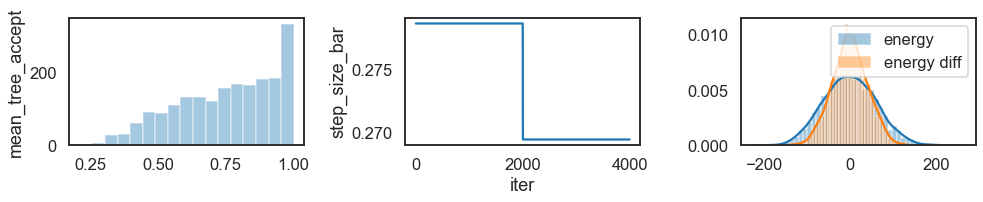

In [209]:
plt.figure(figsize=(14, 3))
plt.subplot(131)
accept = trace.get_sampler_stats('mean_tree_accept', burn=1000)
sns.distplot(accept, kde=False)
plt.ylabel('mean_tree_accept')
plt.subplot(132)
plt.plot(trace['step_size_bar'])
plt.xlabel('iter'); plt.ylabel('step_size_bar')
plt.subplot(133)
energy = trace['energy']
energy_diff = np.diff(energy)
sns.distplot(energy - energy.mean(), label='energy')
sns.distplot(energy_diff, label='energy diff')
plt.legend()
plt.tight_layout()
plt.show()


In [155]:
accept.mean(), trace['diverging'].nonzero()

(0.7436609466999548, (array([], dtype=int64),))

In [ ]:
pm.gelman_rubin(trace)

In [156]:
pm.summary(trace).round(2)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
"w[0,0]",0.95,0.02,0.92,0.99,0.00,0.00,1241.0,1238.0,1247.0,1904.0,1.0
"w[1,0]",-0.12,0.01,-0.15,-0.10,0.00,0.00,3495.0,3313.0,3484.0,2678.0,1.0
"z[0,0]",-0.48,0.53,-1.51,0.49,0.01,0.01,5224.0,2139.0,5260.0,2049.0,1.0
"z[1,0]",-0.30,0.53,-1.34,0.65,0.01,0.01,4243.0,2408.0,4238.0,2911.0,1.0
"z[2,0]",-0.15,0.53,-1.12,0.84,0.01,0.01,6135.0,1339.0,6094.0,2683.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
"z[1663,0]",-1.22,0.52,-2.23,-0.25,0.01,0.01,5164.0,4200.0,5195.0,2788.0,1.0
"z[1664,0]",-1.17,0.54,-2.25,-0.23,0.01,0.00,6031.0,4822.0,6034.0,2642.0,1.0
"z[1665,0]",-1.31,0.53,-2.28,-0.30,0.01,0.01,5521.0,4405.0,5490.0,3030.0,1.0
"z[1666,0]",-1.42,0.52,-2.41,-0.46,0.01,0.00,5706.0,5064.0,5727.0,2692.0,1.0


# Probabilistic PCA on whole brain regions

In [ ]:
Obs_v.shape, Obs_r.shape

In [ ]:
len(Obs_v[ns, :])

In [ ]:
plt.plot(Obs_v.T,'.')
plt.show()

In [ ]:
N = len(Obs_v[ns, :])  # number of data points
D = 84  # data dimensionality
K = 1  # latent dimensionality

In [ ]:
x_train=np.stack((Obs_v+1.86))

In [ ]:
x_train.shape

In [ ]:
plt.plot(x_train[0, :, :], x_train[1,:, :], 'o', color='blue', alpha=0.1)
#plt.axis([-2.2, -1.25, 0, .2])
plt.plot(0,0,'ro')
plt.title("Simulated data set")
plt.show()

In [ ]:
with pm.Model() as PPCA:
    w = pm.Normal('w', mu=tt.zeros([D, K]), sd=1.0 * tt.ones([D, K]), shape=[D, K])
    z = pm.Normal('z', mu=tt.zeros([N, K]), sd=1.0*tt.ones([N, K]), shape=[N, K])
    sigma = pm.HalfCauchy('sigma', beta=1.0)
    x = pm.Normal('x', mu=w.dot(z.T), sd=sigma*tt.ones([D, N]), shape=[D, N], observed=x_train)  

    trace = pm.sample(draws=2000, tune=2000)


In [ ]:
#print(trace.varnames)

In [ ]:
#trace['w'].shape, trace['z'].shape

In [ ]:
# pm.traceplot(trace)
# plt.show()

In [ ]:
w=np.asarray(trace.get_values('w', burn=0, combine=True))
z=np.asarray(trace.get_values('z', burn=0, combine=True))

In [ ]:
w.shape, z.shape

In [ ]:
w_est=np.mean(w, axis=0)
z_est=np.mean(z, axis=0)

In [ ]:
w_est.shape, z_est.shape

In [ ]:
print("Inferred principal axes:")
print(w_est)

In [ ]:
z_est.mean()

In [ ]:
#plt.scatter(x_train[0, :], x_train[1, :], color='blue', alpha=0.1)
plt.hist(z_est, color='r', alpha=0.1, bins=200)
#plt.axis([-10, 10, -10, 10])
plt.title("latent variable z")
plt.show()

In [ ]:
#generate trace from posterior
ppc_trace = pm.sample_posterior_predictive(trace, samples=2000, model=PPCA)

In [ ]:
for key,val in ppc_trace.items():
    print (key, "=>", val)
    print (val.shape)

In [ ]:
x_gen=ppc_trace['x']

In [ ]:
x_train.shape, x_gen.shape

In [ ]:
#plt.figure(figsize=(4, 4))
plt.scatter(x_train[0, :], x_train[1, :], color='b', alpha=0.5)
plt.scatter(x_gen[:,0, :], x_gen[:,1, :],  color='r', alpha=0.01)
#plt.axis([-3.2, -.25, -2, 2])
plt.title("Simulated data set")
plt.show()

In [ ]:
X = np.array((0.))
Y= np.array((0.0))
U = -w_est[0]
V = -w_est[1]

fig, ax = plt.subplots(1,1,figsize=(12,3))
plt.scatter(x_train[0, :], x_train[1, :], color='b', alpha=0.8)
q = ax.quiver(X, Y, U, V,units='xy' ,scale=.22, color='r')
plt.grid()
ax.set_aspect('equal')
# plt.xlim(-2,0)
# plt.ylim(0,1)
plt.show()

In [ ]:
ppc_5=np.percentile(x_gen, [50], axis=0)
ppc_95=np.percentile(x_gen, [97.5], axis=0)

In [ ]:
ppc_5.shape

In [ ]:
plt.scatter(x_train[0, :], x_train[1, :], color='b', alpha=0.8)
plt.scatter(ppc_5[0,0,:], ppc_5[0,1,:], color='r', alpha=0.01)
plt.show()